<a href="https://colab.research.google.com/github/andygma567/Portfolio-Project-1/blob/main/A_small_portfolio_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Abstract**

---

Hi! 

My name is Andrew Ma, I've recently graduated from the University of Texas - Austin with a PhD in Mathematics. I'm seeking a new career in machine learning engineering. To this end I've put together this notebook in order to show off some of the skills in Machine Learning / Data Science with a regression problem. In this notebook I include a discussion on the topics of data cleaning, data preprocessing, building and tuning a neural net in tensorflow, tuning a lasso model (linear regression with an L1 weight), and feature engineering. I look at a small dataset that I got from Kaggle.

---

# **Intro**

Several years ago Zillow hosted a competition on Kaggle to find design a machine learning algorithm to predict the log-error of their "Z-estimates" of home prices based on a dataset recording over 50 features per home (https://www.kaggle.com/competitions/zillow-prize-1/overview).  

The log-error of the "Z-estimate" score is a numerical value and Zillow provided a dataset with properties as rows and a list of the corresponding log-errors for each property. This challenge is an example of a supervised learning regression problem. 

The original dataset provided by Zillow for training contains over 2 million entries. My computational resources are limited to my personal laptop and the Google Colab notebooks. In an effort to accomdate my computational resources I've decided to work with just the first 1000 entries in the provided dataset "properties_2016.csv"

On this smaller dataset, I clean the data, preprocess it with a Standard Scaler from scikit-learn, and then I train and tune a neural net built with tensorflow.keras and using a mean squared error loss function. I then compare my built neural net to a linear regression made with scikit-learn. 

Later I look for additional ways I might be able to improve my linear regression model using regularization and feature engineering. 

# **EDA**

Usually, exploratory data analysis (EDA) includes some amount of summary statistics using pandas and visual inspection of the data using plotting. While I do use Seaborn library to make plots of the aggregated data in my work, I have not included any plots from doing EDA in this notebook for the sake of brevity.

# **Data Cleaning (and Tidying)**

To start, I will need to inspect and clean this dataset. 

From an initial inspection of the columns of my small dataset I thought that the data looked tidy (meaning each row represented one observation and I didn't see any variables used as columns), so I didn't feel the need to use the pandas.melt to rearrange any of the columns. 

I noticed that a number of the column names refered to an 'id' used for categorizing the home that represented by that row of data. I like to One-Hot encode categorical data types but I don't like to use One-Hot encoding on too many variables because this can make my data frame sparse which I think makes it more challenging for machine learning methods for regression to be fitted to the data. 

I decided to set aside just the 'propertylandusetypeid' feature to One-Hot encode later and drop the other features related to 'id's. 

I also decided to drop about 6 additional features. After I read their descriptions in the included file from Zillow I felt that these variables also wouldn't be helpful to train on. 



In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
# This is for changing the directory that I'm in to the Google Drive directory
# This makes it easier for me to access my scripts in the Google Drive directory
import sys
sys.path.append('/content/drive/My Drive')

df = pd.read_csv('/content/drive/My Drive/small_properties_2016.csv')
#df = pd.read_csv('small_properties_2016.csv')

# I plan to one-hot encode this feature later
# For now I will save it for later
column_to_add_later = df['propertylandusetypeid']

lst_of_drops = []
for col in df.columns:
    if 'id' in col:
        lst_of_drops.append(col)
df.drop(lst_of_drops, axis = 1, inplace = True)

#I read about these features and I didn't find them helpful to train on either
df.drop(['propertycountylandusecode', 'fips', 'Unnamed: 0', 
         'rawcensustractandblock', 'censustractandblock', 
         'lotsizesquarefeet'], axis = 1, inplace = True)
# print the features and datatypes
print(df.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   basementsqft                  6 non-null      float64
 1   bathroomcnt                   1000 non-null   float64
 2   bedroomcnt                    1000 non-null   float64
 3   calculatedbathnbr             711 non-null    float64
 4   finishedfloor1squarefeet      676 non-null    float64
 5   calculatedfinishedsquarefeet  938 non-null    float64
 6   finishedsquarefeet12          849 non-null    float64
 7   finishedsquarefeet13          11 non-null     float64
 8   finishedsquarefeet15          77 non-null     float64
 9   finishedsquarefeet50          676 non-null    float64
 10  finishedsquarefeet6           1 non-null      float6

## **Handling Missing Data**

I started by dropping any features/columns that were missing 60% or more of its data. The 60% is an arbitrary number that I generally use as a guideline when choosing the drop features. 

In [ ]:
proportions_na = df.isna().sum()/len(df)*100

# Drop any columns missing 60% of their data.
lst_of_drops = []
for col in df.columns:
    if proportions_na[col] >= 60:
        lst_of_drops.append(col)
df.drop(lst_of_drops, axis = 1, inplace = True)

# Print the percentages missing data for each column/ feature
print('The percentage of missing values per column')
print(df.isna().sum()/len(df)*100)

The percentage of missing values per column
bathroomcnt                      0.0
bedroomcnt                       0.0
calculatedbathnbr               28.9
finishedfloor1squarefeet        32.4
calculatedfinishedsquarefeet     6.2
finishedsquarefeet12            15.1
finishedsquarefeet50            32.4
fireplacecnt                    50.1
fullbathcnt                     28.9
garagecarcnt                    32.0
garagetotalsqft                 32.0
latitude                         0.0
longitude                        0.0
roomcnt                          0.0
yearbuilt                        7.2
numberofstories                 27.8
structuretaxvaluedollarcnt      16.3
taxvaluedollarcnt               13.2
assessmentyear                   0.0
landtaxvaluedollarcnt           13.6
taxamount                        3.1
dtype: float64


### **Single Imputation**

I noticed that certain features such as 'calculatedbathnbr' or  'finishedfloor1squarefeet' were missing data. I thought it was strange that certain home listings in Zillow could have no bathrooms or no finished floors. 

After reading through the data description file that was included with the Zillow data I decided that it's likely some of data entries represent unfinished homes (in the process of being built) or possibly even empty lots. 

By assuming that some data entries represented empty lots / unfinished homes I felt comfortable with filling in a subset of features' missing data with zeroes. The act of filling in data like this is sometimes called simple imputation or single imputation. 

In [ ]:
#Fill in 0s for the following features
make_0_columns = ['calculatedbathnbr', 
                  'finishedfloor1squarefeet', 
                  'finishedsquarefeet12', 
                  'finishedsquarefeet50', 
                  'fireplacecnt', 
                  'fullbathcnt', 
                  'garagecarcnt', 
                  'garagetotalsqft', 
                  'numberofstories']
for col in make_0_columns:
    df[col].fillna(value = 0, inplace = True)

While I was at it I decided to impute the missing values in the 'calculatedfinishedsquarefeet' and 'yearbuilt' by using the values from another column in the same row. 

In [ ]:
# Set calculatedfinishedsquarefeet to be finishedsquarefeet12 
# finishedsquarefeet12 is the sqft of the finished living area and 
# the total calculatedfinishedsquarefeet should be at least as much as this value
df['calculatedfinishedsquarefeet'].fillna(df['finishedsquarefeet12'], inplace = True)

# Set yearbuilt to be assessmentyear because I assume a home needs to be built 
# before it is assessed
df['yearbuilt'].fillna(df['assessmentyear'], inplace = True)

# Print the percentages of missing data per column
print('The percentage of missing values per column')
print(df.isna().sum()/len(df)*100)

The percentage of missing values per column
bathroomcnt                      0.0
bedroomcnt                       0.0
calculatedbathnbr                0.0
finishedfloor1squarefeet         0.0
calculatedfinishedsquarefeet     0.0
finishedsquarefeet12             0.0
finishedsquarefeet50             0.0
fireplacecnt                     0.0
fullbathcnt                      0.0
garagecarcnt                     0.0
garagetotalsqft                  0.0
latitude                         0.0
longitude                        0.0
roomcnt                          0.0
yearbuilt                        0.0
numberofstories                  0.0
structuretaxvaluedollarcnt      16.3
taxvaluedollarcnt               13.2
assessmentyear                   0.0
landtaxvaluedollarcnt           13.6
taxamount                        3.1
dtype: float64


### **Multiple Imputation**

I observed that the remaining features with missing data are dollar amounts related to the value of the home or listing. I don't know how the dollar amounts are determined but I know it should somehow be dependent on the other features of the listing i.e. the total square feet, the number of stories, etc.

I'd like someway to keep these dollar amount features in my data set for training because I think it could be important information. 

I decided that this would be a good opportunity to use multiple imputation from the scikit-learn library. Multiple imputation guesses what a missing value should be based on the other information in the dataset. Through multiple trials of guessing values and scoring the guesses a (hopefully) accurate guess is used to fill in the missing data. 

The code to do this looks as follows:


In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Create the IterativeImputer model to predict missing values
imp = IterativeImputer(max_iter=10, random_state=0)
 
# Fit the model to the test dataset
imp.fit(df)

# Transform the model on the entire dataset
# I checked and it appears most of the original data is rounded to one decimal
dfComplete = pd.DataFrame(np.round(imp.transform(df),1), columns=df.columns)

# The dataset is now complete i.e. it no longer has missing values
print('The percentage of missing values per column')
print(dfComplete.isna().sum()/len(df)*100)

The percentage of missing values per column
bathroomcnt                     0.0
bedroomcnt                      0.0
calculatedbathnbr               0.0
finishedfloor1squarefeet        0.0
calculatedfinishedsquarefeet    0.0
finishedsquarefeet12            0.0
finishedsquarefeet50            0.0
fireplacecnt                    0.0
fullbathcnt                     0.0
garagecarcnt                    0.0
garagetotalsqft                 0.0
latitude                        0.0
longitude                       0.0
roomcnt                         0.0
yearbuilt                       0.0
numberofstories                 0.0
structuretaxvaluedollarcnt      0.0
taxvaluedollarcnt               0.0
assessmentyear                  0.0
landtaxvaluedollarcnt           0.0
taxamount                       0.0
dtype: float64


## **Preprocessing the Data**

### **Variance Threshold**

I have successfully cleaned the data for missing values and now I would like to preprocess my data before training a machine learning model in it. 

To begin my preprocessing I'd like to drop any features in the dataset that have relatively low variance because low variance features will make it difficult for a machine learning algorithm to distinguish between samples. 

To do this I use a variance threshold preprocessor to filter my features. By using the pandas.DataFrame.describe() method I can see that my dataset has a range of values that can sometimes be in the hundreds or thousands for some features. So I arbitrarily decided that a variance threshold of one would be good enough for this dataset. 

In [ ]:
#Now I want to remove the columns that have low variance threshold. From looking at this earlier I decided to go with variance threshold of < 1 
from sklearn.feature_selection import VarianceThreshold
# Before the Variance Threshold I have 21 features
print(len(dfComplete.columns))

selector = VarianceThreshold(threshold=1)
X = selector.fit_transform(dfComplete)
dfComplete = pd.DataFrame(X, columns = selector.get_feature_names_out())
# After the Variance Threshold I have 17 features
print(len(dfComplete.columns))

21
17


### **Rescaling**

Next I'd like to rescale my dataset. Ideally I'd like to use a Min-Max Scaler in order to put all of my data on the same scale between 0 and 1 but from inspecting my dataset it seems that this dataset has some outliers. Outliers make Min-Max Scaling a bad choice because it tends to smash most of the data close together on the 0 to 1 scale. 

So instead, I'll be using a Standard Scaler to make the mean 0 and the standard deviation to be 1. Sometimes this is also referred to as Z-score normalization. 

It would also be interesting to try using a non-linear rescaler like the Quantile Transformer from scikit-learn but I prefer to start with using a Standard Scaler because it's a linear transformation on the dataset, so we won't lose any linear relationships this way. 

I use a Standard Scaler below along with a Column Transformer from scikit-learn

In [ ]:
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
# Make a Column Transformer and apply it to all floating point data types 
# i.e. all of my data in this data frame
ct = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include= 'float64')), 
    remainder='passthrough'
    )
# Apply the Column Transformer
dfComplete_scaled = pd.DataFrame(ct.fit_transform(dfComplete), columns = dfComplete.columns)

Note to self... it might be nice to give before and after pictures of the transformer here...?

With my dataset now fully rescaled I'd like to add back in the 'propertylandusetypeid' feature from earlier as a One-Hot encoding. 

In [ ]:
#One Hot Encoding
# At this point all of my data in dfComplete is full and I can add back in the one-hot encoding
dfComplete_scaled['propertylandusetypeid'] = pd.Categorical(column_to_add_later)
# The get_dummies method is the way we encode categorical data in pandas
dfComplete_scaled = pd.get_dummies(dfComplete_scaled)


At this point I now have a dataset of 29 features with 1000 entries and I'm ready to train a machine learning model on this dataset. 

In [ ]:
print(dfComplete_scaled.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   1000 non-null   float64
 1   bedroomcnt                    1000 non-null   float64
 2   calculatedbathnbr             1000 non-null   float64
 3   finishedfloor1squarefeet      1000 non-null   float64
 4   calculatedfinishedsquarefeet  1000 non-null   float64
 5   finishedsquarefeet12          1000 non-null   float64
 6   finishedsquarefeet50          1000 non-null   float64
 7   fullbathcnt                   1000 non-null   float64
 8   garagetotalsqft               1000 non-null   float64
 9   latitude                      1000 non-null   float64
 10  longitude                     1000 non-null   float64
 11  roomcnt                       1000 non-null   float64
 12  yearbuilt                     1000 non-null   float64
 13  stru

# **Modeling**
I'd like to start by comparing a deep learning neural net with linear regression. Generally, deep learning methods perform better with large amounts of data. With a small dataset like the one that I'm working with in this notebook, containing 1000 entries, we might expect that linear regression will be faster to train and better at predicting. 

I decided to use tensorflow.keras to build my neural network and I'd like my neural network to contain the following parts:

* 2 - 6 hidden layers 
* 32 - 256 nodes per layer
* A 'relu' or 'sigmoid' activation function
* A mean squared error loss function
* A learning rate between 0.00001 and 0.01 
* Dropout layers for regularization (to prevent overfitting)
* Batch Normalization in between hidden layers (to help more accurate training)

Fortunately, thanks to the Keras-Tuner ([Keras Tuner API](https://keras.io/keras_tuner/)) it's easy to use the specifications above to define a parameter space to search for models in. 

To get started, I need to install the *Keras-Tuner* in this notebook

In [ ]:
# I need to install the keras tuner with pip, using the flag --quiet prevents pip from showing the output
!pip install keras-tuner --quiet

Next, I define a subclass of *keras_tuner.HyperModel* so that I can customize the *build* method to build neural networks that have the specifications described in the bullet points above.  

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras_tuner

#for reproducibility of result I always use the same seed for the random number generator. 
tf.random.set_seed(42) 

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Input(shape = (29,)))
        for i in range(hp.Int("num_layers", 2, 6)):
            model.add(
                Dense(
                    # Tune number of units separately.
                    units=hp.Int(f"num_nodes_{i}", min_value=32, max_value=256, step=32),
                    activation=hp.Choice(f"activation", values = ["relu", "sigmoid"])
                )
            )
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
        model.add(Dense(1))
        
        lr = hp.Float("learning_rate", min_value = 1e-5, max_value = 1e-2)
        # Use an Adam optimizer and also record the mean absolute error, 'mae', as I go. 
        model.compile(optimizer = Adam(learning_rate = lr), loss = 'mean_squared_error', metrics = ['mae'])
        return model

## **Tuning the Neural Network**


I'm now ready to create the tuner and search the hyperparameter space. The Keras Tuner provides several options for searching the hyperparameter space:


* RandomSearch Tuner
* Sklearn Tuner
* BayesOptimization Tuner
* Hyperband Tuner

The first two options are similar to RandomSearchCV and GridSearchCV, respectively, commonly used in scikit-learn. The BayesOptimization Tuner searches the hyperparameter space more efficiently by using Bayes Optimization to make educated guesses on what hyperparameter settings to try based on previously tried hyperparameter settings (Please see Appendix for more information). It's interesting to note that the site (https://scikit-optimize.github.io/stable/index.html) offers Bayes Optimized Searching built for scikit-learn.  

For this dataset, I would like to use the Hyperband Tuner. This strategy builds a wide variety of neural network models and  sets up a tournament style bracket to compare model performance. Each model is run for a few epochs while monitoring their performance and the worst performing models are eliminated while the best performing models are run for more epochs. This process gets repeated until a single model is selected. ([Link to the 2016 ArXiv paper on Hyperband](https://arxiv.org/abs/1603.06560)).

First, I'll load my dataset and split it into a training portion and a testing portion. It may be important to add that I similarly cleaned the labels dataset originally from Zillow but I did not show the steps for cleaning it here. 

In [ ]:
# The features will be my cleaned dataset from earlier
features = dfComplete_scaled
# Read in the labels data
labels = pd.read_csv('/content/drive/My Drive/cleaned_small_train_2016_v2.csv')
# The labels originally have several unneccesary columns of information that
# needs to be dropped
labels.drop(['Unnamed: 0'], axis = 1, inplace = True)

#For splitting the training and testing data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.15)
# I think I need to convert my data to numpy arrays because keras doesn't 
# like lists of lists 
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

Here's my code for creating and running a Hyperband Tuner. For this setup it takes me 3-5 min running on a TPU in a Google Colab notebook before I obtain a best model


In [ ]:
# Create a Hyperband Tuner 
tuner = keras_tuner.Hyperband(hypermodel = MyHyperModel(),
    objective='val_loss',
    max_epochs = 20,
    #max_epochs=60,
    factor=3, 
    executions_per_trial=2, 
    overwrite=True,
    project_name="MyTuner"
    )

# Search the parameter space
tuner.search(
    x_train, y_train, 
    epochs = 60,
    batch_size = 16, 
    verbose = 1, 
    validation_split = 0.2
    )

Trial 30 Complete [00h 00m 19s]
val_loss: 0.008661333471536636

Best val_loss So Far: 0.007299746852368116
Total elapsed time: 00h 04m 16s
INFO:tensorflow:Oracle triggered exit


When we are done tuning the neural network model we can look at details of the best performing model. 


In [ ]:
# Get the top model.
models = tuner.get_best_models(num_models=1)
best_model = models[0]
# Build the model
best_model.summary()
# Show the best hyperparameters
tuner.results_summary(1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               5760      
                                                                 
 batch_normalization (BatchN  (None, 192)              768       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                6176      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

I would like to train the best model on more epochs to see if the mean squared error can be improved by training for more epochs. In the previous tuning I only trained models for 20 epochs and now I'd like to try to training the same model on up to 100 epochs. 

I'll also use an early stopping callback based on validation loss so that I don't train my model excessively long and I'll use a 20% cross validation split on the training data. 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Create an early stopping callback for validation loss
es = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0, 
    patience = 40)

# Refit the best model for 100 epochs
history = best_model.fit(
    x_train, 
    y_train, 
    epochs=100, 
    batch_size = 16, 
    validation_split = 0.2, 
    verbose = 0, 
    callbacks = [es])

Now that I've refit my best neural network model I would like to know if my model is underfitting or overfitting my training data. I check this by calling the *evaluate* method on my model using the testing data I set aside earlier but I think it would be interesting and fun to look a plot of the loss and validation loss during the model training. 

Below is some code to plot the results of retraining my model. The plot on the left shows the mean squared error of the loss and the validation loss. 

The plot on the right will show the mean absolute error that was also tracked during the training. 

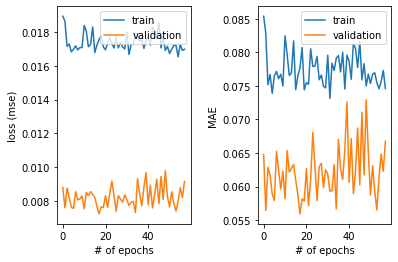

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

#plotting
fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 1, 'wspace': 0.5}) 
(ax1, ax2) = axs
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='validation')
ax1.legend(loc="upper right")
ax1.set_xlabel("# of epochs")
ax1.set_ylabel("loss (mse)")

ax2.plot(history.history['mae'], label='train')
ax2.plot(history.history['val_mae'], label='validation')
ax2.legend(loc="upper right")
ax2.set_xlabel("# of epochs")
ax2.set_ylabel("MAE")

plt.show()
plt.clf()

If the validation loss is greater than the loss during training then it's possible that my model is overfitting the training data. On the otherhand, if the validation loss is less than the loss during training then it could be the case that my model is underfitting the training data. 

Finally, I'd like to evaluate my model on the testing data and I'd like to compare the my model's performance to linear regression run on the same dataset as a benchmark. 

In [ ]:
# Compare the nn to a linear regressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
# Recast the output of train test split into numpy arrays before 
# passing the data to my linear regressor
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
lin_mse = mean_squared_error(y_pred, y_test)

val_mse, val_mae = best_model.evaluate(x_test, y_test, verbose = 0)
print("Neural Net MSE: ", val_mse)
print('Linear Reg. MSE: ', lin_mse)

Neural Net MSE:  0.017025159671902657
Linear Reg. MSE:  0.017662602167069857


We can see that my neural network model performs comparably to linear regression despite taking longer to train. This is not very surprising because the dataset that I am using in this example is small (1000 samples). Deep Learning methods tend to do better than classical machine learning methods when working with large amounts of data. 

It would be interesting to compare my model's performance to linear regression on the full dataset (more than 2 million samples). 

For now, I'd like to optimize linear regression on my small dataset to see if the mean squared error can be reduced more. 

## **Tuning Linear Regression**

I'm going to try using Lasso, an L1 based regularization of linear regression. Hopefully, Lasso will perform even better than my previous linear regression. 

I considered using BayesSearchCV search from the skopt library to tune the L1 weight parameter in Lasso but I found that scikit-learn already includes a version of Lasso that uses gradient descent to find the optimal L1 weight ( [skopt BayesSearchCV API](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)). It even uses cross validation so I don't feel the need to any of the parameter tuning methods such as GridSearchCV or RandomSearchCV. 

Here is an example of using Lasso in comparision to using Linear Regression. 

LassoCV MSE:  0.00038659929500878433
LassoCV alpha value:  0.0018859341934165993
Linear Reg. MSE:  0.01650309159303255


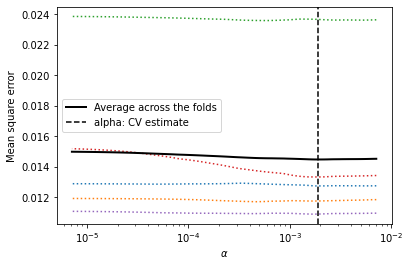

<Figure size 432x288 with 0 Axes>

In [ ]:
# Compare the Lasso to a linear regressor
from sklearn.linear_model import LassoCV

# Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.15)
# I need to flatten the y_train array for lasso training or else it prints a warning
y_train = np.asarray(y_train).ravel()

# I think LassoCV already does the tuning so that I don't need to do a BayesSearchCV on it
lasso = LassoCV(eps = 1e-3, max_iter=5000, tol=0.001)
lr = LinearRegression()
# Fit both models
lasso.fit(x_train, y_train)
lr.fit(x_train, y_train)
# Use the fitted models on the test data 
lasso_y_pred = lasso.predict(x_test)
y_pred = lr.predict(x_test)
# Calculate the Mean Squared Errors for comparison
lasso_mse = mean_squared_error(y_pred, lasso_y_pred)
lin_mse = mean_squared_error(y_pred, y_test)
print("LassoCV MSE: ", lasso_mse)
print('LassoCV alpha value: ', lasso.alpha_)
print('Linear Reg. MSE: ', lin_mse)
# Plot the results of tuning LassoCV
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()

plt.show()
plt.clf()

In the graph above the dotted lines represents the results of a single trial of cross validation. By default LassoCV uses 5 fold cross validation and the solid black line represents the average of all of the cross validation trials. 

The parameter alpha is used in the definition of the loss function for LassoCV ([scikit-learn LassoCV API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html))

Loss = MSE + alpha* L1-norm of parameters

We can see that LassoCV has a better MSE on our testing data compared to Linear Regression but the MSE of both are pretty close and that might be because of how small the optimally choosen value of alpha is. 

### **Feature Engineering**

I would like to see if I can improve the mean squared error of my Lasso model by using feature selection or feature extraction. 

To begin, I'll investigate feature selection using the Recursive Feature Elimination (RFE) approach from scikit-learn. This approach involves training a model on all of the available features, ranking each feature's importance, dropping the least important feature, and repeating this process on the remaining features until a predetermined number of features is left. 

I also consider trying Sequential Forward Selection and Sequential Backward Selection which might be more thorough ways of selecting features but I decided to use RFE because it is faster. 



In [ ]:
from sklearn.feature_selection import RFE
# Use RFE to reduce the number of features from 29 originally to 15
# I selected 15 features after trying a variety of numbers
selector = RFE(estimator = lr, n_features_to_select= 15)
X = selector.fit_transform(features, labels)

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.15)
y_train = np.asarray(y_train).ravel()

lr = LinearRegression()
lasso = LassoCV(eps = 1e-3, max_iter=5000, tol=0.001)

lr.fit(x_train, y_train)
lasso.fit(x_train, y_train)

y_pred = lr.predict(x_test)
lasso_y_pred = lasso.predict(x_test)

lasso_mse = mean_squared_error(y_pred, lasso_y_pred)
lin_mse = mean_squared_error(y_pred, y_test)

print("LassoCV MSE after RFE(15 features): ", lasso_mse)
#print('LassoCV alpha value: ', lasso.alpha_)
print('Linear Reg. MSE after RFE(15 features): ', lin_mse)

LassoCV MSE after RFE(15 features):  0.0010234871454129167
Linear Reg. MSE after RFE(15 features):  0.009484076302200127


The results of using RFE seem to be comparable or even slightly worse than not using RFE on the data. This might mean that I'll need to keep all of the features if I want the smallest possible error although if I'm willing to accept slightly worse mean squared errors then I could drop roughly half of the features from the dataset. 

Next I want to try a feature extraction approach. I will try a dimension reduction on my full set of features using Principal Component Analysis (PCA) to see if that improves the mean squared error from lasso or linear regression. 

Normally when examining a variety of preprocessing transforms and estimators it might be a good idea to build a pipeline in scikit-learn to bundle these steps together but for a single experiement I resuse most of the code from RFE. 

In [ ]:
# I want to do PCA to go from 29 features to 15
# I chose 15 features after trying a few different numbers
from sklearn.decomposition import PCA
pca = PCA(n_components = 15)
X = pd.DataFrame(pca.fit_transform(features))

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.15)

y_train = np.asarray(y_train).ravel()

lr = LinearRegression()
lasso = LassoCV(eps = 1e-3, max_iter=5000, tol=0.001)

lr.fit(x_train, y_train)
lasso.fit(x_train, y_train)

y_pred = lr.predict(x_test)
lasso_y_pred = lasso.predict(x_test)

lasso_mse = mean_squared_error(y_pred, lasso_y_pred)
lin_mse = mean_squared_error(y_pred, y_test)

print("LassoCV MSE after PCA(15 features): ", lasso_mse)
#print('LassoCV alpha value: ', lasso.alpha_)
print('Linear Reg. MSE after PCA(15 features): ', lin_mse)

LassoCV MSE after PCA(15 features):  0.0006208405413218714
Linear Reg. MSE after PCA(15 features):  0.021248541210212548


It seems that applying PCA for reducing the dimension of the dataset does not lead to great improvements for the mean squared error compared to using the full dataset in either of lasso or linear regression. It's possible that there is a slight improvement by using PCA but this would be better seen by running multiple trials and either averaging the mean squared error results or plotting a histogram of the errors. 

For the time being I think it's safe to say that for a using lasso is a better option than linear regression on my dataset of 1000 entries and while feature selection methods like RFE and feature extraction methods like PCA are nice, in this case it doesn't lead to any significant improvements. 





# **Conclusion**

After cleaning my data I made a dataset of about 1000 entries with 29 features to a regression train on. 

I found that linaer regression gave a smaller mean squared error compared to a neural net on this dataset. In one trial I did (not listed in this notebook) I had the following mean squared error for a neural of 6 layers with total 27,000 parameters. 

> Neural Net MSE:  0.029488882049918175

> Linear Reg. MSE:  0.023287213589404897

Meanwhile a Lasso model trained on the same dataset had a MSE of 

> LassoCV MSE:  0.0003934555890057121

This was a couple orders of magnitude better. I tried to improve this MSE by using feature selection and feature extraction on my dataset before but I did not see any significant improvements. 

It's not surprising to see that Lasso outperformed a neural network considering that my training dataset is rather small. 

# **Possible Further Work**
In follow up it would be nice to see try out some of scikit-learn's other built-in models for regression such as Ridge, Elastic-Net, or even something like decision tree - regression to see if any other models work better on this small dataset of 1000 examples. 

It would also be important to see how accurate the models I tried are when used on the full dataset of over 2 million entries. For example, deep learning algorithms generally seem to perform better when trained on larger amounts of data so it's possible that the deep learning model I made earlier would be the better than linear regression or lasso on the full dataset. 

Unrelated to this work, I have future goals to continue studying current popular machine learning libraries such as XGBoost. I also would like to continue studying deep learning by doing a project in image classification where I build an autoencoder to use alongside a Convolution Neural Network. 

Thanks for your interest. 

# **Appendix**


## **Resources for Learning more about Bayes Optimization**

Here’s some links that I read that I found helpful for learning Bayes Optimized search:

1.   This is a simpler broad overview of some big picture ideas of Bayes Search but done through the library hyperopt - I would only suggest skimming this article for buzzwords.
[Bayesian Optimization for quicker hyperparameter tuning](https://www.vantage-ai.com/en/blog/bayesian-optimization-for-quicker-hyperparameter-tuning)

2.   This is more of middle ground between math and big picture ideas: https://proceedings.neurips.cc/paper/2012/file/05311655a15b75fab86956663e1819cd-Paper.pdf


3.  This is an article that goes into detail of some of the math. I liked it but I only read up to section 2.3 b/c I didn’t find the rest of it helpful.
https://arxiv.org/pdf/1012.2599.pdf

4. [Extra] This is a video explaining what a Gaussian process is. I liked the presentation for the helpful pictures: https://www.youtube.com/watch?v=92-98SYOdlY&feature=emb_title

5. Finally, here’s a link to the [API of BayesSearchCV in skopt](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html). It works basically like the stuff in scikit learn but be careful that you may need to specify which data in your search space is Real a.k.a. Numerical and what is Categorical (Please see the second link on Bayes optimization in skopt for more detail)

